In [1]:
import makemore as mm

In [2]:
import torch

In [33]:
import os
import sys
import time
import math
import argparse
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt

In [38]:
import torch.nn as nn
from torch.nn import functional as F

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [6]:
#args
seed = 101010
work_dir = '/home/ubuntu/models' #run `mkdir models` first
input_file = 'names.txt'

#Model Args
n_layer=4
n_embd=64
n_embd2=64
n_head=64
device='cuda:0'

#Trainer Args
learning_rate=3e-4
weight_decay=1e-2
batch_size = 10
num_workers = 2
max_steps = 100

In [7]:
# system inits
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.makedirs(work_dir, exist_ok=True)
writer = mm.SummaryWriter(log_dir=work_dir)

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [8]:
os.getcwd()

'/home/ubuntu/makemore'

In [9]:
# init datasets
train_dataset, test_dataset = mm.create_datasets(input_file)
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_output_length()
print(f"dataset determined that: {vocab_size=}, {block_size=}")

number of examples in the dataset: 32033
max word length: 15
number of unique characters in the vocabulary: 26
vocabulary:
abcdefghijklmnopqrstuvwxyz
split up the dataset into 31033 training examples and 1000 test examples
dataset determined that: vocab_size=27, block_size=16


In [11]:
# init model
config = mm.ModelConfig(vocab_size=vocab_size, block_size=block_size,
                   n_layer=n_layer, n_head=n_head,
                   n_embd=n_embd, n_embd2=n_embd2)
model = mm.Transformer(config)
model.to(device)
print(f"model #params: {sum(p.numel() for p in model.parameters())}")
# if args.resume or args.sample_only: # note: if we sample-only then we also assume we are resuming
#     print("resuming from existing model in the workdir")
#     model.load_state_dict(torch.load(os.path.join(args.work_dir, 'model.pt')))
# if args.sample_only:
#     print_samples(num=50)
#     sys.exit()

# init optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
    betas=(0.9, 0.99), 
    eps=1e-8
)
# init dataloader
batch_loader = mm.InfiniteDataLoader(
    train_dataset, 
    batch_size=batch_size, 
    pin_memory=True, 
    num_workers=num_workers
)

number of parameters: 0.20M


In [15]:
# training loop
best_loss = None
step = 0
while True:

    t0 = time.time()

    # get the next batch, ship to device, and unpack it to input and target
    batch = batch_loader.next()
    batch = [t.to(device) for t in batch]
    X, Y = batch

    # feed into the model
    logits, loss = model(X, Y)

    # calculate the gradient, update the weights
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # wait for all CUDA work on the GPU to finish then calculate iteration time taken
    if device.startswith('cuda'):
        torch.cuda.synchronize()
    t1 = time.time()

    # logging
    if step % 10 == 0:
        print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")

    # evaluate the model
    if step > 0 and step % 500 == 0:
        train_loss = evaluate(model, train_dataset, batch_size=100, max_batches=10)
        test_loss  = evaluate(model, test_dataset,  batch_size=100, max_batches=10)
        writer.add_scalar("Loss/train", train_loss, step)
        writer.add_scalar("Loss/test", test_loss, step)
        writer.flush()
        print(f"step {step} train loss: {train_loss} test loss: {test_loss}")
        # save the model to disk if it has improved
        if best_loss is None or test_loss < best_loss:
            out_path = os.path.join(work_dir, "model.pt")
            print(f"test loss {test_loss} is the best so far, saving model to {out_path}")
            torch.save(model.state_dict(), out_path)
            best_loss = test_loss

    # sample from the model
    if step > 0 and step % 200 == 0:
        print_samples(num=10)

    step += 1
    # termination conditions
    if max_steps >= 0 and step >= max_steps:
        break

step 0 | loss 3.4336 | step time 803.14ms
step 10 | loss 3.0155 | step time 19.60ms
step 20 | loss 2.9193 | step time 18.95ms
step 30 | loss 2.6380 | step time 18.81ms
step 40 | loss 2.6422 | step time 18.07ms
step 50 | loss 2.6594 | step time 16.11ms
step 60 | loss 2.7239 | step time 22.88ms
step 70 | loss 2.6593 | step time 20.81ms
step 80 | loss 2.5451 | step time 20.72ms
step 90 | loss 2.4382 | step time 20.60ms


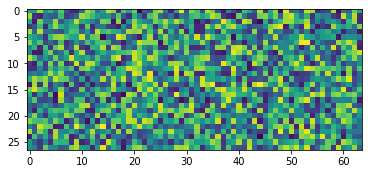

In [25]:
params = dict(model.named_parameters())
a = params['lm_head.weight'].detach().to('cpu').numpy()
imgplot = plt.imshow(a)
plt.show()

## Model Analysis

### Peel 1 layer into Transformer

In [71]:
# init model
config = mm.ModelConfig(vocab_size=vocab_size, block_size=block_size,
                   n_layer=n_layer, n_head=n_head,
                   n_embd=n_embd, n_embd2=n_embd2)
model = mm.Transformer(config)
model.to(device)
print(f"model #params: {sum(p.numel() for p in model.parameters())}")
# if args.resume or args.sample_only: # note: if we sample-only then we also assume we are resuming
#     print("resuming from existing model in the workdir")
#     model.load_state_dict(torch.load(os.path.join(args.work_dir, 'model.pt')))
# if args.sample_only:
#     print_samples(num=50)
#     sys.exit()

# init optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
    betas=(0.9, 0.99), 
    eps=1e-8
)
# init dataloader
batch_loader = mm.InfiniteDataLoader(
    train_dataset, 
    batch_size=batch_size, 
    pin_memory=True, 
    num_workers=num_workers
)

number of parameters: 0.20M
model #params: 204544


In [72]:
# This could be run without for loop, step by step
for i in range(1000):
    # get the next batch, ship to device, and unpack it to input and target
    batch = batch_loader.next()
    batch = [t.to(device) for t in batch]
    X, Y = batch

    #---*----# feed into the model - this is the entrypoint to Transformer
    idx = X
    targets = Y

    device = idx.device
    b, t = idx.size()
    assert t <= model.block_size, f"Cannot forward sequence of length {t}, block size is only {model.block_size}"
    pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

    # forward the GPT model itmodel
    tok_emb = model.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
    pos_emb = model.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
    x = tok_emb + pos_emb
    for block in model.transformer.h:
        x = block(x)
    x = model.transformer.ln_f(x)
    logits = model.lm_head(x)

    # if we are given some desired targets also calculate the loss
    loss = None
    if targets is not None:
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
    #---*----# feed into the model - the exitpoint is producing logits, loss
        
    # calculate the gradient, update the weights
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if i%100==0:
        print(loss)
        print(i)

tensor(3.4725, device='cuda:0', grad_fn=<NllLossBackward0>)
0
tensor(2.4679, device='cuda:0', grad_fn=<NllLossBackward0>)
100
tensor(2.3647, device='cuda:0', grad_fn=<NllLossBackward0>)
200
tensor(2.3020, device='cuda:0', grad_fn=<NllLossBackward0>)
300
tensor(2.4096, device='cuda:0', grad_fn=<NllLossBackward0>)
400
tensor(2.2575, device='cuda:0', grad_fn=<NllLossBackward0>)
500
tensor(2.4116, device='cuda:0', grad_fn=<NllLossBackward0>)
600
tensor(2.2563, device='cuda:0', grad_fn=<NllLossBackward0>)
700
tensor(2.3391, device='cuda:0', grad_fn=<NllLossBackward0>)
800
tensor(2.1611, device='cuda:0', grad_fn=<NllLossBackward0>)
900


In [73]:
# wait for all CUDA work on the GPU to finish then calculate iteration time taken
if device.type.startswith('cuda'):
    torch.cuda.synchronize()

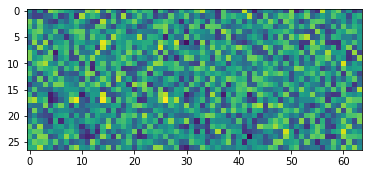

In [74]:
params = dict(model.named_parameters())
a = params['lm_head.weight'].detach().to('cpu').numpy()
imgplot = plt.imshow(a)
plt.show()

### Peel 2 layers into Transformer...block

In [78]:
# init model
config = mm.ModelConfig(vocab_size=vocab_size, block_size=block_size,
                   n_layer=n_layer, n_head=n_head,
                   n_embd=n_embd, n_embd2=n_embd2)
model = mm.Transformer(config)
model.to(device)
print(f"model #params: {sum(p.numel() for p in model.parameters())}")
# if args.resume or args.sample_only: # note: if we sample-only then we also assume we are resuming
#     print("resuming from existing model in the workdir")
#     model.load_state_dict(torch.load(os.path.join(args.work_dir, 'model.pt')))
# if args.sample_only:
#     print_samples(num=50)
#     sys.exit()

# init optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
    betas=(0.9, 0.99), 
    eps=1e-8
)
# init dataloader
batch_loader = mm.InfiniteDataLoader(
    train_dataset, 
    batch_size=batch_size, 
    pin_memory=True, 
    num_workers=num_workers
)

number of parameters: 0.20M
model #params: 204544


In [79]:
# This could be run without for loop, step by step
for i in range(1000):
    # get the next batch, ship to device, and unpack it to input and target
    batch = batch_loader.next()
    batch = [t.to(device) for t in batch]
    X, Y = batch

    #---*----# feed into the model - this is the entrypoint to Transformer
    idx = X
    targets = Y

    device = idx.device
    b, t = idx.size()
    assert t <= model.block_size, f"Cannot forward sequence of length {t}, block size is only {model.block_size}"
    pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

    # forward the GPT model itmodel
    tok_emb = model.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
    pos_emb = model.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
    x = tok_emb + pos_emb
    for block in model.transformer.h:
        x = x + block.attn(block.ln_1(x))
        x = x + block.mlpf(block.ln_2(x))
    x = model.transformer.ln_f(x)
    logits = model.lm_head(x)

    # if we are given some desired targets also calculate the loss
    loss = None
    if targets is not None:
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
    #---*----# feed into the model - the exitpoint is producing logits, loss
        
    # calculate the gradient, update the weights
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if i%100==0:
        print(loss)
        print(i)

tensor(3.3299, device='cuda:0', grad_fn=<NllLossBackward0>)
0
tensor(2.3034, device='cuda:0', grad_fn=<NllLossBackward0>)
100
tensor(2.3206, device='cuda:0', grad_fn=<NllLossBackward0>)
200
tensor(2.4974, device='cuda:0', grad_fn=<NllLossBackward0>)
300
tensor(2.3009, device='cuda:0', grad_fn=<NllLossBackward0>)
400
tensor(2.5012, device='cuda:0', grad_fn=<NllLossBackward0>)
500
tensor(2.2566, device='cuda:0', grad_fn=<NllLossBackward0>)
600
tensor(2.2890, device='cuda:0', grad_fn=<NllLossBackward0>)
700
tensor(2.1087, device='cuda:0', grad_fn=<NllLossBackward0>)
800
tensor(2.3717, device='cuda:0', grad_fn=<NllLossBackward0>)
900


In [80]:
# wait for all CUDA work on the GPU to finish then calculate iteration time taken
if device.type.startswith('cuda'):
    torch.cuda.synchronize()

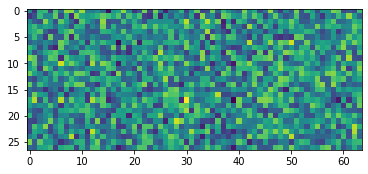

In [81]:
params = dict(model.named_parameters())
a = params['lm_head.weight'].detach().to('cpu').numpy()
imgplot = plt.imshow(a)
plt.show()

### Peel 3 layers into Transformer...block

In [99]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# init model
config = mm.ModelConfig(vocab_size=vocab_size, block_size=block_size,
                   n_layer=n_layer, n_head=n_head,
                   n_embd=n_embd, n_embd2=n_embd2)
model = mm.Transformer(config)
model.to(device)
print(f"model #params: {sum(p.numel() for p in model.parameters())}")
# if args.resume or args.sample_only: # note: if we sample-only then we also assume we are resuming
#     print("resuming from existing model in the workdir")
#     model.load_state_dict(torch.load(os.path.join(args.work_dir, 'model.pt')))
# if args.sample_only:
#     print_samples(num=50)
#     sys.exit()

# init optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
    betas=(0.9, 0.99), 
    eps=1e-8
)
# init dataloader
batch_loader = mm.InfiniteDataLoader(
    train_dataset, 
    batch_size=batch_size, 
    pin_memory=True, 
    num_workers=num_workers
)

number of parameters: 0.20M
model #params: 204544


In [100]:
# This could be run without for loop, step by step

for i in range(1000):
    # get the next batch, ship to device, and unpack it to input and target
    batch = batch_loader.next()
    batch = [t.to(device) for t in batch]
    X, Y = batch

    #---*----# feed into the model - this is the entrypoint to Transformer
    idx = X
    targets = Y

    device = idx.device
    b, t = idx.size()
    assert t <= model.block_size, f"Cannot forward sequence of length {t}, block size is only {model.block_size}"
    pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

    # forward the GPT model itmodel
    tok_emb = model.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
    pos_emb = model.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
    x = tok_emb + pos_emb
    for block in model.transformer.h:
        # attention
        layer_normed1 = block.ln_1(x)
        attn = block.attn(layer_normed1)
        x = x + attn #residual connection
        # mlpf
        layer_normed2 = block.ln_2(x)
        fully_connected = block.mlp.c_fc(layer_normed2)
        activated = block.mlp.act(fully_connected)
        projected = block.mlp.c_proj(activated)
        # mlpf = block.mlp.c_proj(block.mlp.act(block.mlp.c_fc((block.ln_2(x)))))
        x = x + projected #residual connection
    x = model.transformer.ln_f(x)
    logits = model.lm_head(x)

    # if we are given some desired targets also calculate the loss
    loss = None
    if targets is not None:
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
    #---*----# feed into the model - the exitpoint is producing logits, loss
        
    # calculate the gradient, update the weights
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if i%100==0:
        print(loss)
        print(i)

tensor(3.4626, device='cuda:0', grad_fn=<NllLossBackward0>)
0
tensor(2.4464, device='cuda:0', grad_fn=<NllLossBackward0>)
100
tensor(2.3241, device='cuda:0', grad_fn=<NllLossBackward0>)
200
tensor(2.4042, device='cuda:0', grad_fn=<NllLossBackward0>)
300
tensor(2.5085, device='cuda:0', grad_fn=<NllLossBackward0>)
400
tensor(2.1440, device='cuda:0', grad_fn=<NllLossBackward0>)
500
tensor(2.2406, device='cuda:0', grad_fn=<NllLossBackward0>)
600
tensor(2.1675, device='cuda:0', grad_fn=<NllLossBackward0>)
700
tensor(2.3986, device='cuda:0', grad_fn=<NllLossBackward0>)
800
tensor(2.5864, device='cuda:0', grad_fn=<NllLossBackward0>)
900


In [80]:
# wait for all CUDA work on the GPU to finish then calculate iteration time taken
if device.type.startswith('cuda'):
    torch.cuda.synchronize()

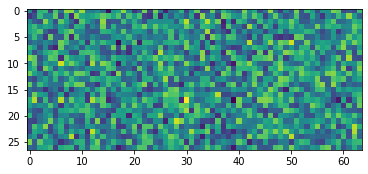

In [81]:
params = dict(model.named_parameters())
a = params['lm_head.weight'].detach().to('cpu').numpy()
imgplot = plt.imshow(a)
plt.show()

### Peel 4 layers into Transformer...block

In [101]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# init model
config = mm.ModelConfig(vocab_size=vocab_size, block_size=block_size,
                   n_layer=n_layer, n_head=n_head,
                   n_embd=n_embd, n_embd2=n_embd2)
model = mm.Transformer(config)
model.to(device)
print(f"model #params: {sum(p.numel() for p in model.parameters())}")
# if args.resume or args.sample_only: # note: if we sample-only then we also assume we are resuming
#     print("resuming from existing model in the workdir")
#     model.load_state_dict(torch.load(os.path.join(args.work_dir, 'model.pt')))
# if args.sample_only:
#     print_samples(num=50)
#     sys.exit()

# init optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
    betas=(0.9, 0.99), 
    eps=1e-8
)
# init dataloader
batch_loader = mm.InfiniteDataLoader(
    train_dataset, 
    batch_size=batch_size, 
    pin_memory=True, 
    num_workers=num_workers
)

number of parameters: 0.20M
model #params: 204544


In [102]:
# This could be run without for loop, step by step

for i in range(1000):
    # get the next batch, ship to device, and unpack it to input and target
    batch = batch_loader.next()
    batch = [t.to(device) for t in batch]
    X, Y = batch

    #---*----# feed into the model - this is the entrypoint to Transformer
    idx = X
    targets = Y

    device = idx.device
    b, t = idx.size()
    assert t <= model.block_size, f"Cannot forward sequence of length {t}, block size is only {model.block_size}"
    pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

    # forward the GPT model itmodel
    tok_emb = model.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
    pos_emb = model.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
    x = tok_emb + pos_emb
    for block in model.transformer.h:
        # attention
        layer_normed1 = block.ln_1(x)
        B, T, C = layer_normed1.size()
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = block.attn.c_attn(x).split(block.attn.n_embd, dim=2)        
        k = k.view(B, T, block.attn.n_head, C // block.attn.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, block.attn.n_head, C // block.attn.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, block.attn.n_head, C // block.attn.n_head).transpose(1, 2) # (B, nh, T, hs)        
        
        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(block.attn.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        
        # output projection
        y = block.attn.c_proj(y)        
        
        x = x + y #residual connection
        # mlpf
        layer_normed2 = block.ln_2(x)
        fully_connected = block.mlp.c_fc(layer_normed2)
        activated = block.mlp.act(fully_connected)
        projected = block.mlp.c_proj(activated)
        # mlpf = block.mlp.c_proj(block.mlp.act(block.mlp.c_fc((block.ln_2(x)))))
        x = x + projected #residual connection
    x = model.transformer.ln_f(x)
    logits = model.lm_head(x)

    # if we are given some desired targets also calculate the loss
    loss = None
    if targets is not None:
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
    #---*----# feed into the model - the exitpoint is producing logits, loss
        
    # calculate the gradient, update the weights
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if i%100==0:
        print(loss)
        print(i)

tensor(3.4339, device='cuda:0', grad_fn=<NllLossBackward0>)
0
tensor(2.4484, device='cuda:0', grad_fn=<NllLossBackward0>)
100
tensor(2.3278, device='cuda:0', grad_fn=<NllLossBackward0>)
200
tensor(2.3863, device='cuda:0', grad_fn=<NllLossBackward0>)
300
tensor(2.5157, device='cuda:0', grad_fn=<NllLossBackward0>)
400
tensor(2.1427, device='cuda:0', grad_fn=<NllLossBackward0>)
500
tensor(2.2240, device='cuda:0', grad_fn=<NllLossBackward0>)
600
tensor(2.1723, device='cuda:0', grad_fn=<NllLossBackward0>)
700
tensor(2.3887, device='cuda:0', grad_fn=<NllLossBackward0>)
800
tensor(2.5691, device='cuda:0', grad_fn=<NllLossBackward0>)
900


In [80]:
# wait for all CUDA work on the GPU to finish then calculate iteration time taken
if device.type.startswith('cuda'):
    torch.cuda.synchronize()

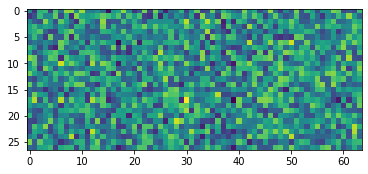

In [81]:
params = dict(model.named_parameters())
a = params['lm_head.weight'].detach().to('cpu').numpy()
imgplot = plt.imshow(a)
plt.show()

### Questions

1. how does the shape of the tensors change at each step?
2. how are the elements of tensors changing at each step?

    a. what did they represent before the step
    
    b. what do they represent after?
3. what is an 'intuitive' description of the transformation at each step

To answer these questions, we're going to operate on just one block and remove For loops

In [103]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# init model
config = mm.ModelConfig(vocab_size=vocab_size, block_size=block_size,
                   n_layer=n_layer, n_head=n_head,
                   n_embd=n_embd, n_embd2=n_embd2)
model = mm.Transformer(config)
model.to(device)
print(f"model #params: {sum(p.numel() for p in model.parameters())}")
# if args.resume or args.sample_only: # note: if we sample-only then we also assume we are resuming
#     print("resuming from existing model in the workdir")
#     model.load_state_dict(torch.load(os.path.join(args.work_dir, 'model.pt')))
# if args.sample_only:
#     print_samples(num=50)
#     sys.exit()

# init optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay,
    betas=(0.9, 0.99), 
    eps=1e-8
)
# init dataloader
batch_loader = mm.InfiniteDataLoader(
    train_dataset, 
    batch_size=batch_size, 
    pin_memory=True, 
    num_workers=num_workers
)

number of parameters: 0.20M
model #params: 204544


In [104]:
# This could be run without for loop, step by step

# get the next batch, ship to device, and unpack it to input and target
batch = batch_loader.next()
batch = [t.to(device) for t in batch]
X, Y = batch

#---*----# feed into the model - this is the entrypoint to Transformer
idx = X #entrpoint argument to Transformer callable
targets = Y #entrpoint argument to Transformer callable

device = idx.device
b, t = idx.size()
assert t <= model.block_size, f"Cannot forward sequence of length {t}, block size is only {model.block_size}"
pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

# forward the GPT model itmodel
tok_emb = model.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
pos_emb = model.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
x = tok_emb + pos_emb
block = model.transformer.h[0] #WE TAKE ONLY ONE block!  #for block in model.transformer.h:

# attention
layer_normed1 = block.ln_1(x)
B, T, C = layer_normed1.size() # batch size, sequence length, embedding dimensionality (n_embd)

# calculate query, key, values for all heads in batch and move head forward to be the batch dim
q, k ,v  = block.attn.c_attn(x).split(block.attn.n_embd, dim=2)        
k = k.view(B, T, block.attn.n_head, C // block.attn.n_head).transpose(1, 2) # (B, nh, T, hs)
q = q.view(B, T, block.attn.n_head, C // block.attn.n_head).transpose(1, 2) # (B, nh, T, hs)
v = v.view(B, T, block.attn.n_head, C // block.attn.n_head).transpose(1, 2) # (B, nh, T, hs)        

# causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
att = att.masked_fill(block.attn.bias[:,:,:T,:T] == 0, float('-inf'))
att = F.softmax(att, dim=-1)
y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

# output projection
y = block.attn.c_proj(y)        

x = x + y #residual connection
# mlpf
layer_normed2 = block.ln_2(x)
fully_connected = block.mlp.c_fc(layer_normed2)
activated = block.mlp.act(fully_connected)
projected = block.mlp.c_proj(activated)
# mlpf = block.mlp.c_proj(block.mlp.act(block.mlp.c_fc((block.ln_2(x)))))
x = x + projected #residual connection
x = model.transformer.ln_f(x)
logits = model.lm_head(x)

# if we are given some desired targets also calculate the loss
loss = None
if targets is not None:
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
#---*----# feed into the model - the exitpoint is producing logits, loss

# calculate the gradient, update the weights
model.zero_grad(set_to_none=True)
loss.backward()
optimizer.step()

In [114]:
import numpy as np

In [165]:
tz = -torch.ones((1,4))

In [167]:
tz[0,0] = -np.inf

In [158]:
torch.round(F.softmax(tz,dim=1), decimals=2)

tensor([[0.0000, 0.3300, 0.3300, 0.3300]])

In [159]:
tz

tensor([[-inf, 1., 1., 1.]])

In [161]:
np.exp(0)

1.0

In [168]:
torch.round(torch.exp(tz), decimals=2)

tensor([[0.0000, 0.3700, 0.3700, 0.3700]])